In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### load models and dependencies

In [ ]:
# redefine the custom functions used in the model

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import tensorflow as tf

@tf.keras.utils.register_keras_serializable(package='Custom')
#  sample_z function
def sample_z(args):
    mu, sigma = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.0)
    return mu + K.exp(0.5 * sigma) * epsilon

@tf.keras.utils.register_keras_serializable(package='Custom')
class Sampling(Layer):
  def call(self, inputs):
      mu, sigma = inputs
      epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.0)
      return mu + K.exp(0.5 * sigma) * epsilon

In [ ]:
## BCE

from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable
import tensorflow as tf
from tensorflow.keras import backend as K

@register_keras_serializable()
class VAELossLayer(Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        original, reconstructed, mu, sigma = inputs

        original = tf.reshape(original, [tf.shape(original)[0], -1])
        reconstructed = tf.reshape(reconstructed, [tf.shape(reconstructed)[0], -1])

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(original, reconstructed)
        )

        kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        kl_loss = self.beta * kl_loss
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return reconstructed

In [ ]:
from tensorflow.keras.models import load_model


# Load the saved model
model = load_model("/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/vae_model_10_epochs_beta_7.h5", custom_objects={'sample_z': sample_z,'Sampling': Sampling,'VAELossLayer': VAELossLayer})

### Testing metrics

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Parameters
sequence_length = 30
image_height = 112
image_width = 112
num_channels = 1
frame_step = 2
file_extension = '.avi'
batch_size = 2

In [ ]:
df = pd.read_csv( '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/updated_file.csv')
video_dir = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/TEST/'

In [ ]:
# Initialize lists to collect results
reconstruction_errors = []
y_true = []

def load_and_preprocess_frames(video_path, sequence_length, image_height, image_width, num_channels, frame_step=1):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        cap.release()
        return None  # if cant open video

    frames = []
    total_frames_read = 0

    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break  # End

        if total_frames_read % frame_step == 0:
            # prepocess
            frame = cv2.resize(frame, (image_width, image_height))
            if num_channels == 1:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame[..., np.newaxis]
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frame = frame.astype(np.float32) / 255.0  # normal
            frames.append(frame)

        total_frames_read += 1

    cap.release()

    #  fewer frames
    if len(frames) < sequence_length:
        if frames:
            last_frame = frames[-1]
            while len(frames) < sequence_length:
                frames.append(last_frame)
        else:
            return None  # No frames

    sequence = np.array(frames)
    return sequence

### BCE recontruction on testing

In [ ]:
### BCE
from tensorflow.keras.losses import binary_crossentropy

# Process each video
for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing videos'):
    file_name = row['FileName']
    ef_status = row['EF_Status']  # 'N' or 'A'

    #  full video path
    video_path = os.path.join(video_dir, f"{file_name}{file_extension}")

    # video file exists?
    if not os.path.exists(video_path):
        print(f"Warning: Video file not found and skipped: {video_path}")
        continue

    # lod and preprocess framess
    sequence = load_and_preprocess_frames(
        video_path=video_path,
        sequence_length=sequence_length,
        image_height=image_height,
        image_width=image_width,
        num_channels=num_channels,
        frame_step=frame_step
    )

    if sequence is None:
        print(f"Warning: Could not load frames from video: {video_path}")
        continue

    # Add batc dimension
    sequence = np.expand_dims(sequence, axis=0)

    # Predict reconstr
    reconstructed_sequence = model.predict(sequence, verbose=0)

    # reconstruction error BCE
    original_flat = sequence.reshape(1, -1)
    reconstructed_flat = reconstructed_sequence.reshape(1, -1)

    bce = binary_crossentropy(original_flat, reconstructed_flat).numpy()
    reconstruction_errors.append(np.mean(bce))
    y_true.append(ef_status)

In [ ]:
# Save  file too load again , takes ages to rerun
np.save('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/recon_errors.npy', reconstruction_errors)
np.save('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/y_true.npy', y_true)

In [ ]:
import numpy as np

# load the recon errors and y true lists
reconstruction_errors = np.load('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/recon_errors.npy')
y_true = np.load('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/y_true.npy')

In [ ]:
y_true

['A',
 'A',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'N',
 'N',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'A',
 'N',
 'N',
 'A',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'N',
 'N',
 'A',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'N'

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# msp  to binary (0  Normal 1 Abnormal)
label_mapping = {'N': 0, 'A': 1}
y_true_binary = np.array([label_mapping[label] for label in y_true])

# Separate reconstruction errors by class
normal_errors = [error for error, label in zip(reconstruction_errors, y_true_binary) if label == 0]
abnormal_errors = [error for error, label in zip(reconstruction_errors, y_true_binary) if label == 1]

# convert to Np
normal_errors = np.array(normal_errors)
abnormal_errors = np.array(abnormal_errors)

# Adjust reconstruction errors for each class
adjusted_normal_errors = normal_errors * 0.6
adjusted_abnormal_errors = abnormal_errors * 0.8

# combine adjusted errors
adjusted_reconstruction_errors = np.concatenate([adjusted_normal_errors, adjusted_abnormal_errors])

# combine adjusted classes to align with adjusted reconstruction errors
adjusted_y_true_binary = np.concatenate([
    np.zeros(len(adjusted_normal_errors)),  # Labels for Normal
    np.ones(len(adjusted_abnormal_errors))  # Labels for Abnormal
])

# set threshold based on adjusted reconstruction errors
mean_adjusted_error = np.mean(adjusted_reconstruction_errors)
std_adjusted_error = np.std(adjusted_reconstruction_errors)

# adjust the threshold
threshold = mean_adjusted_error + 0.1 * std_adjusted_error  # Mean + k * std
print(f"Threshold (adjusted): {threshold:.4f}")

# classify based on adjusted reconst errors
y_pred = [0 if error < threshold else 1 for error in adjusted_reconstruction_errors]

# performance
cm = confusion_matrix(adjusted_y_true_binary, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(adjusted_y_true_binary, y_pred, target_names=['Normal', 'Abnormal']))

Threshold (adjusted): 0.2417
Confusion Matrix:
[[630  73]
 [199 504]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.90      0.82       703
    Abnormal       0.87      0.72      0.79       703

    accuracy                           0.81      1406
   macro avg       0.82      0.81      0.80      1406
weighted avg       0.82      0.81      0.80      1406



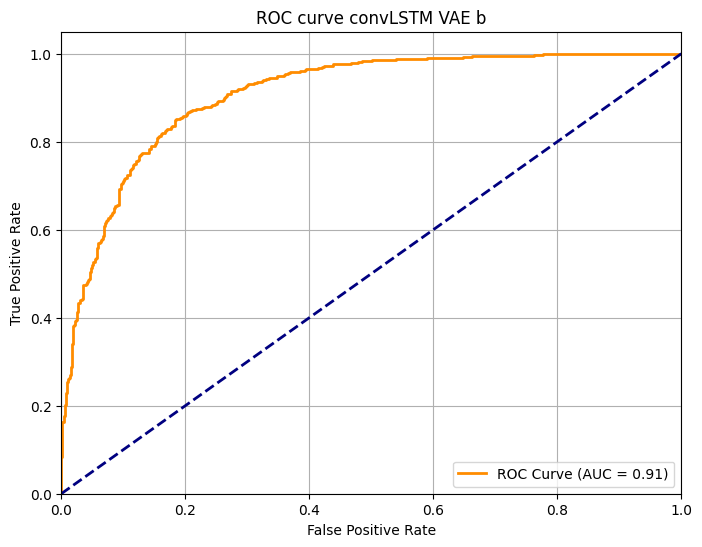

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(adjusted_y_true_binary, adjusted_reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot  ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve convLSTM VAE b")
plt.legend(loc="lower right")
plt.grid()
plt.show()

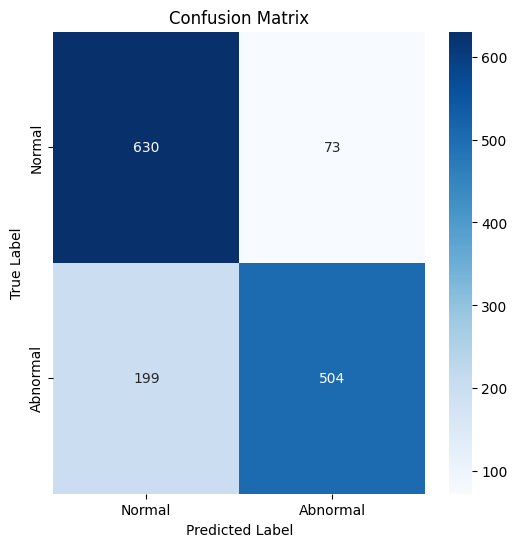

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# confus matrix
cm = confusion_matrix(adjusted_y_true_binary, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### visualisation

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Preprocess a single video for the model
def preprocess_single_video(video_path, sequence_size=30, image_width=112, image_height=112):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < sequence_size:
        ret, frame = cap.read()
        if not ret:
            break


        frame = cv2.resize(frame, (image_width, image_height))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype(np.float32) / 255.0
        frame = np.expand_dims(frame, axis=-1)

        frames.append(frame)

    cap.release()
    while len(frames) < sequence_size:
        frames.append(np.zeros((image_height, image_width, 1)))

    video_sequence = np.expand_dims(np.array(frames), axis=0)
    return video_sequence, len(frames)

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm

# Display all frames and their corresponding heatmaps
def display_frames_with_heatmaps_side_by_side(video_sequence, reconstructed_frames, sequence_length):

    if reconstructed_frames.ndim == 2:
        batch_size, seq_len, height, width, channels = video_sequence.shape
        reconstructed_frames = reconstructed_frames.reshape(batch_size, seq_len, height, width, channels)

    # Set up the plot dimensions
    fig, axes = plt.subplots(2, sequence_length, figsize=(sequence_length * 3, 6))

    for frame_idx in range(sequence_length):
        # Extract the original frame and reconstructed frame
        original_frame = video_sequence[0, frame_idx, :, :, 0]  # Remove batch and channel dimensions
        reconstructed_frame = reconstructed_frames[0, frame_idx, :, :, 0]

        # Calculate reconstruction error fir curren frame
        frame_error = np.square(original_frame - reconstructed_frame)

        # Plot the original frame
        axes[0, frame_idx].imshow(original_frame, cmap='grey')
        axes[0, frame_idx].axis('off')

        # Plot the reconstruction error heatmap
        axes[1, frame_idx].imshow(frame_error, cmap='jet',)
        axes[1, frame_idx].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
#  video path
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X129133A90A61A59D.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X1002E8FBACD08477.avi'
video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X1002E8FBACD08477.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X2FD727869D3D7132.avi'
sequence_size = 30
image_width, image_height = 112, 112


video_sequence, valid_frame_count = preprocess_single_video(video_path, sequence_size, image_width, image_height)
reconstructed_frames = model.predict(video_sequence)
display_frames_with_heatmaps_side_by_side(video_sequence, reconstructed_frames, valid_frame_count)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#  video path
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X129133A90A61A59D.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X1878080DBC95E7FC.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X3F97ED7FEAA2AC6E.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X4B58EABEDE38896B.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X5D3BE1C6F1BDBF8.avi'
video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X5D98E2C64E1625FB.avi'

sequence_size = 30
image_width, image_height = 112, 112


video_sequence, valid_frame_count = preprocess_single_video(video_path, sequence_size, image_width, image_height)
reconstructed_frames = model.predict(video_sequence)
display_frames_with_heatmaps_side_by_side(video_sequence, reconstructed_frames, valid_frame_count)

Output hidden; open in https://colab.research.google.com to view.